# Evaluate robustness of loss hyperparameter lambda - the spatial loss strength (Fig S15 - 17)

In [1]:
import itertools
import warnings
from functools import partial
import os
import torch
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as sio
from sklearn.metrics import roc_auc_score, average_precision_score

from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.deconv import NNLS, NuSVR, DWLS, LogNormReg
from smoother.visualization import *

import matplotlib
import matplotlib.pyplot as plt

from plotnine import *
from plotnine_prism import *

In [2]:
DATA_FOLDER = "/Users/jysumac/Projects/Smoother_paper/data/synthetic_deconv/donut/"
RES_FOLDER = "/Users/jysumac/Projects/Smoother_paper/results/synthetic_deconv/donut/"
dict_markers = {'20':'Top 20 (n=283)', '50':'Top 50 (n=656)', '0':'All specific (n=2693)', 'c':'CARD-selected (n=7972)'}

Empirical knowledges from exploratory analyses:
1. L1 normalization on weights seems not important
2. Regression should be done on the log-space

## Deconvolute on all data (9 scenarios, each with 10 experiments) - Torch

In [3]:
def _load_data(data_dir, exp):
    # load true celltype abundances
    ab_true = pd.read_csv(data_dir + f"/celltype_abundances.csv", header = 0, index_col = 0)
    celltypes = ab_true.columns
    
    coords = pd.read_csv(f"{data_dir}/deconv_inputs/coords_exp{exp}.csv", header = 0, index_col = 0)
    # spatial counts
    sp_counts = sio.mmread(
        f"{data_dir}/deconv_inputs/syn_sp_count_markers_exp{exp}.mtx"
    ).toarray().T
        
    # reference count matrices
    ref_counts = pd.read_csv(
        f"{data_dir}/deconv_inputs/ref_avg_norm_count_markers.csv", header = 0, index_col = 0)
    ref_counts = ref_counts[celltypes]

    # convert data into torch tensor
    x_c = torch.tensor(ref_counts.values).float()
    y_c = torch.tensor(sp_counts).float()

    x_lc = torch.log1p(x_c)
    y_lc = torch.log1p(y_c)

    # calculate spatial weight matrix
    weights = SpatialWeightMatrix()
    weights.calc_weights_knn(coords)
    weights.scale_by_expr(y_lc)
    
    spatial_loss = SpatialLoss('icar', weights, rho = 0.99)
    
    return x_lc, y_lc, spatial_loss

def deconv_all_exp_torch_lambda(data_dir, model, num_exp = 10):
    torch.manual_seed(20220731)

    p_inf_exp_list = []
    runtime_exp_list = []
    lambda_list = [0, 0.1, 0.3, 1, 3, 10]
    deconv_configs = {'max_epochs':-1, 'lr':3e-3, 'quiet':True}
    
    assert model in ['nnls', 'dwls', 'svr']
    if model == 'nnls':
        func = NNLS
    elif model == 'dwls':
        func = partial(DWLS, nonneg=True, max_weights=4)
    else:
        func = partial(NuSVR, nu=0.1, nonneg=True)
    
    method_names = [f'{model}_sp{str(l)}' for l in lambda_list]

    for exp in range(num_exp):
        print(f"Deconvoluting experiment {exp} ...")
        x, y, spatial_loss = _load_data(data_dir, exp)
        
        # run deconvolution with different lambdas
        deconv_models = []
        for l in [0, 0.1, 0.3, 1, 3, 10]:
            model = func()
            model.deconv(x, y, spatial_loss,
                         lambda_spatial_loss=l, **deconv_configs)
            deconv_models.append(model)

        # extract celltype proportions
        prop_inf = [m.get_props().numpy() for m in deconv_models]
        p_inf_exp_list.append(np.stack(prop_inf))
        
        # extract runtime
        runtime = [m.deconv_time for m in deconv_models]
        runtime_exp_list.append(np.stack(runtime))

    return method_names, p_inf_exp_list, runtime_exp_list

def save_deconv_results(res_dir, method_names, p_inf_exp_list, runtime_exp_list):
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)
    
    assert len(p_inf_exp_list) == len(runtime_exp_list)
    
    runtime_df = pd.DataFrame(np.stack(runtime_exp_list), 
                              columns=method_names)
    runtime_df.to_csv(res_dir + "/runtime.csv")
    
    num_exp = len(p_inf_exp_list)
    for exp in range(num_exp):
        for m, name in enumerate(method_names):
            np.savetxt(res_dir + f"/{name}_e{exp}.txt", p_inf_exp_list[exp][m,:,:])

### NNLS

In [4]:
for nm, sm in itertools.product(['20', '50', '0', 'c'], ['0', '0.1', '0.5']):
    dir_name = f"ne10_rz15_nm{nm}_sm{sm}"
    print(f"===== {dir_name} =====")
    model = 'nnls'
    data_dir = os.path.join(DATA_FOLDER, dir_name)
    res_dir = os.path.join(RES_FOLDER, dir_name, f"lambda_sp_torch/{model}/")

    method_names, p_inf_exp_list, runtime_exp_list = deconv_all_exp_torch_lambda(data_dir, model, 10)
    save_deconv_results(res_dir, method_names, p_inf_exp_list, runtime_exp_list)

===== ne10_rz15_nm20_sm0 =====
Deconvoluting experiment 0 ...
Number of spots: 2500. Average number of neighbors per spot:  5.37.
Number of spots: 2500. Average number of neighbors per spot:  5.37.


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

### DWLS

In [ ]:
for nm, sm in itertools.product(['20', '50', '0', 'c'], ['0', '0.1', '0.5']):
    dir_name = f"ne10_rz15_nm{nm}_sm{sm}"
    print(f"===== {dir_name} =====")
    model = 'dwls'
    data_dir = os.path.join(DATA_FOLDER, dir_name)
    res_dir = os.path.join(RES_FOLDER, dir_name, f"lambda_sp_torch/{model}/")
    method_names, p_inf_exp_list, runtime_exp_list = deconv_all_exp_torch_lambda(data_dir, model, 10)
    save_deconv_results(res_dir, method_names, p_inf_exp_list, runtime_exp_list)

### SVR 

In [ ]:
for nm, sm in itertools.product(['20', '50', '0', 'c'], ['0', '0.1', '0.5']):
    dir_name = f"ne10_rz15_nm{nm}_sm{sm}"
    print(f"===== {dir_name} =====")
    model = 'svr'
    data_dir = os.path.join(DATA_FOLDER, dir_name)
    res_dir = os.path.join(RES_FOLDER, dir_name, f"lambda_sp_torch/{model}/")
    method_names, p_inf_exp_list, runtime_exp_list = deconv_all_exp_torch_lambda(data_dir, model, 10)
    save_deconv_results(res_dir, method_names, p_inf_exp_list, runtime_exp_list)

## Evaluate deconvolution performance

### Calculate benchmark stats

In [3]:
def load_deconv_results(data_dir, res_dir, model, num_exp = 10):
    # load true cell type abundances
    ab_true = pd.read_csv(data_dir + f"/celltype_abundances.csv", header = 0, index_col = 0)
    celltypes = ab_true.columns

    # calculate proportion
    p_true = pd.DataFrame(
        ab_true.to_numpy() / (ab_true.to_numpy().sum(axis=1, keepdims=True) + 1e-10),
        index = ab_true.index, columns = ab_true.columns
    )
    
    # [n_spots x n_celltypes, ...]
    p_true_exp_list = [p_true.iloc[(2500*exp):(2500 + 2500*exp),:].to_numpy()
                       for exp in range(num_exp)]

    # load spatial pattern annotation
    design = pd.read_csv(data_dir + f"/celltype_zone_assignment.csv", header = 0, index_col = 0)
    design = design.loc[celltypes,:]
    
    # load deconvolution results
    lambda_list = [0, 0.1, 0.3, 1, 3, 10]
    file_names = [f'{model}_sp{str(l)}' for l in lambda_list]

    # [n_methods x n_spots x n_celltypes, ...]
    p_inf_exp_list = [
        np.stack([np.loadtxt(f"{res_dir}/{name}_e{exp}.txt") for name in file_names])
        for exp in range(num_exp)]
    
    return p_true_exp_list, p_inf_exp_list, design


def _array2df(array, value_name, method_names, design):
    # array: n_celltypes x n_methods
    df = pd.DataFrame(array, columns = method_names)
    df['cell_type'] = design.index
    df['is_high_density'] = design['is_high_density'][df['cell_type']].values
    df = pd.melt(
        df, id_vars=['cell_type', 'is_high_density'],
        var_name='model', value_name=value_name
    )
    df['deconv_model'] = df['model'].str.split('_sp').str[0]
    df['lambda_sp'] = df['model'].str.split('_sp').str[1]
    df['lambda_sp'] = pd.Categorical(df.lambda_sp, [str(d) for d in[0, 0.1, 0.3, 1, 3, 10]])
    df['cell_type_class'] = np.where(df.is_high_density, 'High abundance', 'Low abundance')
    
    return df

def calc_deconv_stats(p_true_exp_list, p_inf_exp_list, design, method_names, 
                      corr_metric = 'pearson', accu_metric = 'pr', is_present_threshold = 0.05):
    err_exp_df = [] # absolute deconv error
    corr_exp_df = [] # deconv correlation
    accu_exp_df = [] # binary accuracy metric

    # check correlation metric
    assert corr_metric in ['pearson', 'spearman']
    if corr_metric == 'pearson':
        corr_func = lambda p_true, p_inf: np.corrcoef(p_true, p_inf)[0,1]
    else:
        corr_func = lambda p_true, p_inf: sp.stats.spearmanr(p_true, p_inf).correlation
    
    # check binary accuracy metric
    assert accu_metric in ['roc', 'pr']
    if accu_metric == 'roc':
        _accu_func = roc_auc_score
    else:
        _accu_func = average_precision_score
        
    def accu_func(y_true, y_inf, **kwargs):
        try:
            return _accu_func(y_true, y_inf, average='micro', **kwargs)
        except ValueError as verr:
            #print(f"Return NaN accuracy because of the following error: {verr}")
            return np.nan
    
    # iterate over experiments        
    for exp, (p_true_exp, p_inf_exp) in enumerate(zip(p_true_exp_list, p_inf_exp_list)):
        # calculate mean square error of cell type proportions
        err_df = np.stack([((p_true_exp - p_inf_exp[model,:,:]) ** 2).mean(axis=0) 
                           for model in range(p_inf_exp.shape[0])], axis=1)
        err_df = _array2df(err_df, 'mse', method_names, design)
        err_df['exp'] = exp
        err_exp_df.append(err_df)

        # calculate pearson correlation between true and predicted
        corr_df = np.stack(
            [np.array([corr_func(p_true_exp[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        corr_df = _array2df(corr_df, 'corr', method_names, design)
        corr_df['exp'] = exp
        corr_exp_df.append(corr_df)

        # calculate binary prediction accuracy
        is_ct_present = p_true_exp >= is_present_threshold
        accu_df = np.stack(
            [np.array([accu_func(is_ct_present[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        accu_df = _array2df(accu_df, 'accu', method_names, design)
        accu_df['exp'] = exp
        accu_exp_df.append(accu_df)
        
    err_exp_df = pd.concat(err_exp_df)
    corr_exp_df = pd.concat(corr_exp_df)
    accu_exp_df = pd.concat(accu_exp_df)
    
    return err_exp_df, corr_exp_df, accu_exp_df

### NNLS

In [4]:
err_l = []
corr_l = []
accu_l = []
lambda_list = [0, 0.1, 0.3, 1, 3, 10]
method = 'nnls'
method_names = [f'{method}_sp{str(l)}' for l in lambda_list]

corr_metric='pearson'
accu_metric='pr'

for nm, sm in itertools.product(['c', '0', '20', '50'], ['0', '0.1', '0.5']):
    data_dir = f"{DATA_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/"
    res_dir = f"{RES_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/" + \
        f"lambda_sp_torch/{method}/"
    
    # load deconv results
    p_true_exp_list, p_inf_exp_list, design = load_deconv_results(data_dir, res_dir, method)
    
    # calculate performance stats
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        err_exp_df, corr_exp_df, accu_exp_df  = calc_deconv_stats(
            p_true_exp_list, p_inf_exp_list, design, method_names, corr_metric, accu_metric)
    
    err_exp_df['nm'] = nm
    err_exp_df['sm'] = sm
    corr_exp_df['nm'] = nm
    corr_exp_df['sm'] = sm
    accu_exp_df['nm'] = nm
    accu_exp_df['sm'] = sm
    
    err_l.append(err_exp_df)
    corr_l.append(corr_exp_df)
    accu_l.append(accu_exp_df)

def _list2df(l):
    df = pd.concat(l)
    df['deconv_model'] = df['deconv_model'].str.upper()
    df['nm'] = pd.Categorical(
        df.nm, ['20', '50', '0', 'c']
    ).rename_categories(dict_markers)
    return df
    
err_all_df = _list2df(err_l)
corr_all_df = _list2df(corr_l)
accu_all_df = _list2df(accu_l)

#### Absolute errors

In [5]:
df = err_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                  'exp', 'nm', 'sm'])
df_diff_err = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                  'lambda_sp', 'is_high_density']]
df_diff_err['err_diff'] = df['mse'].to_numpy() - \
    np.repeat(df[df.lambda_sp == '0']['mse'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/2732821099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


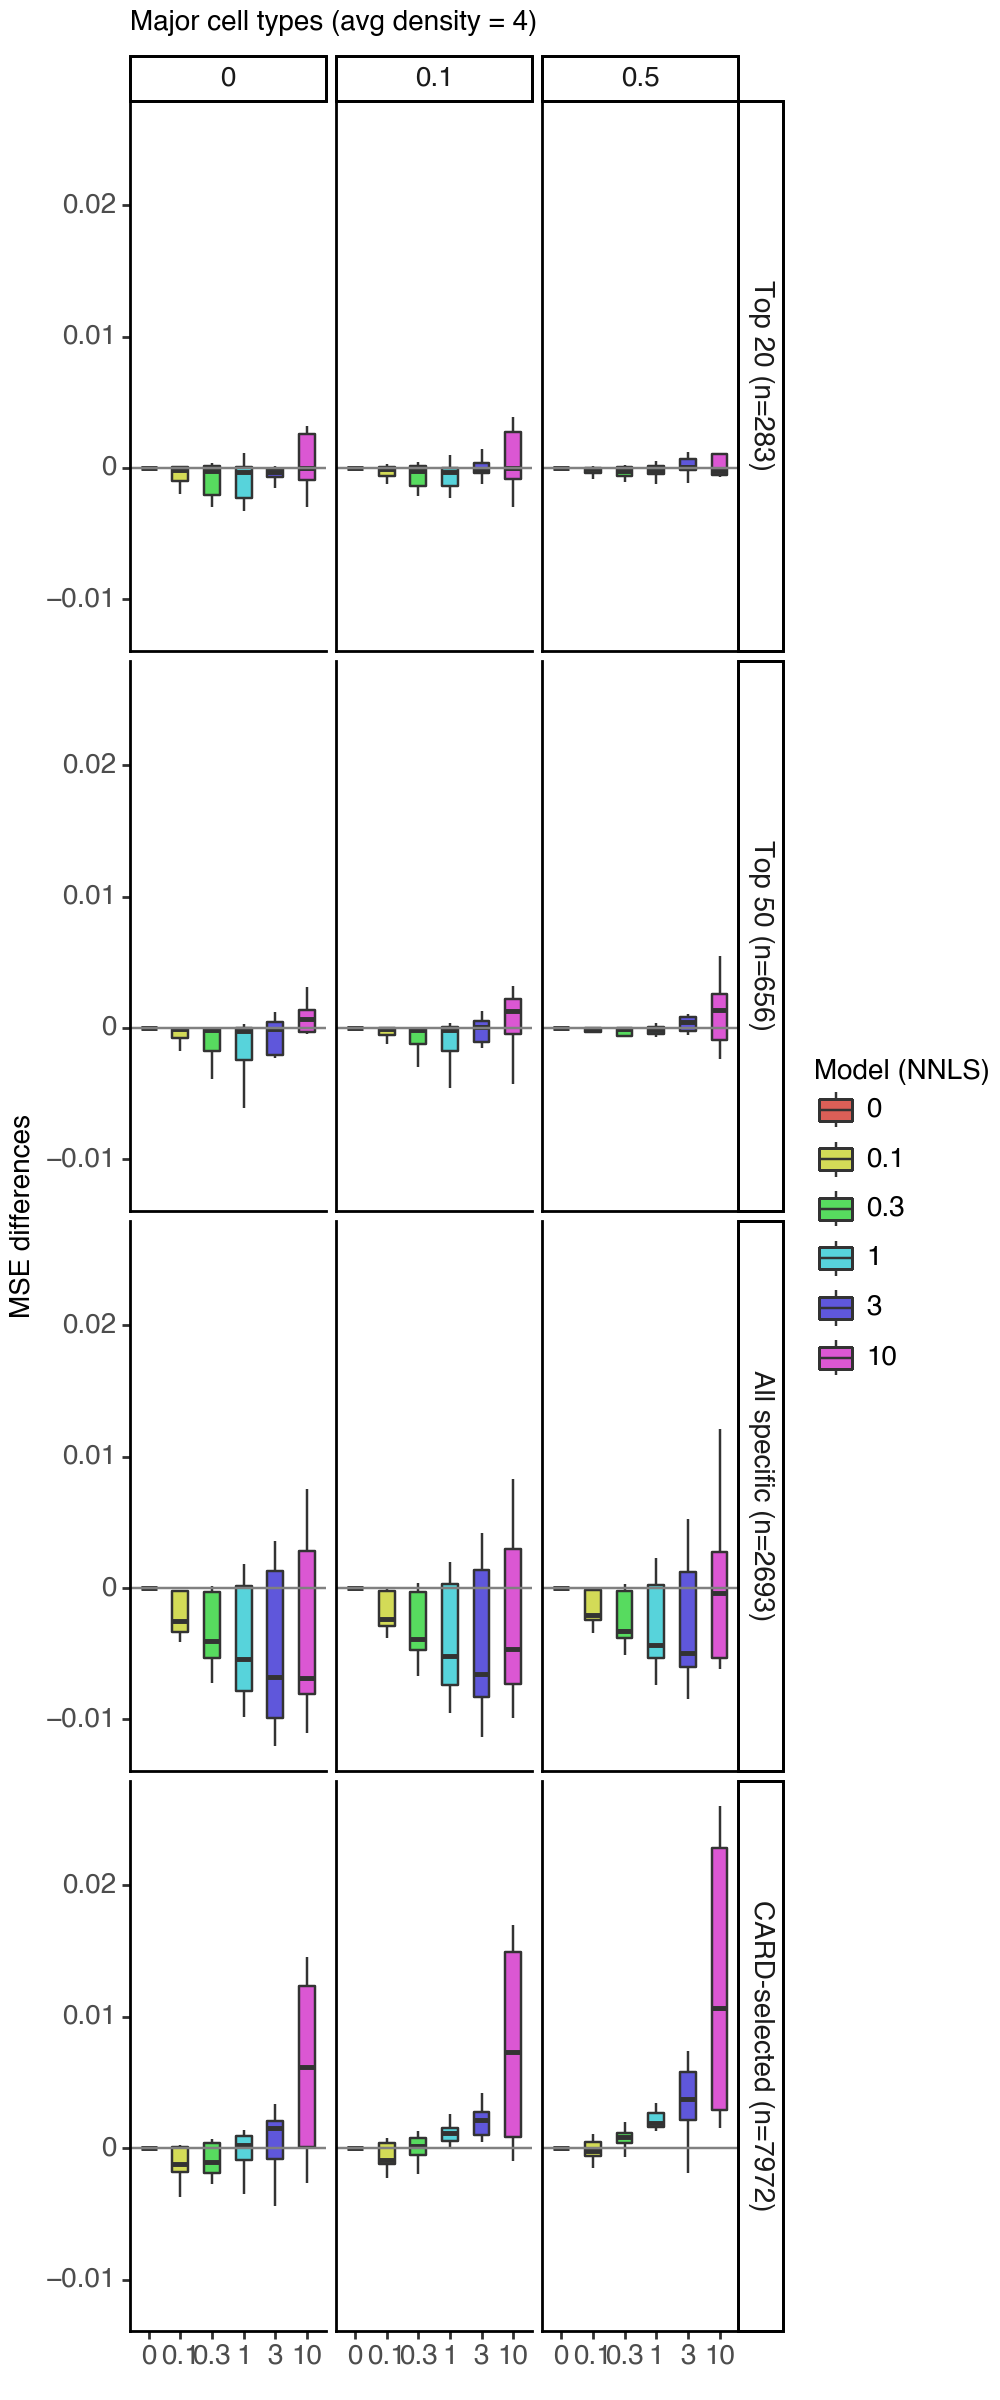

<Figure Size: (500 x 1200)>

In [6]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 1], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (NNLS)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

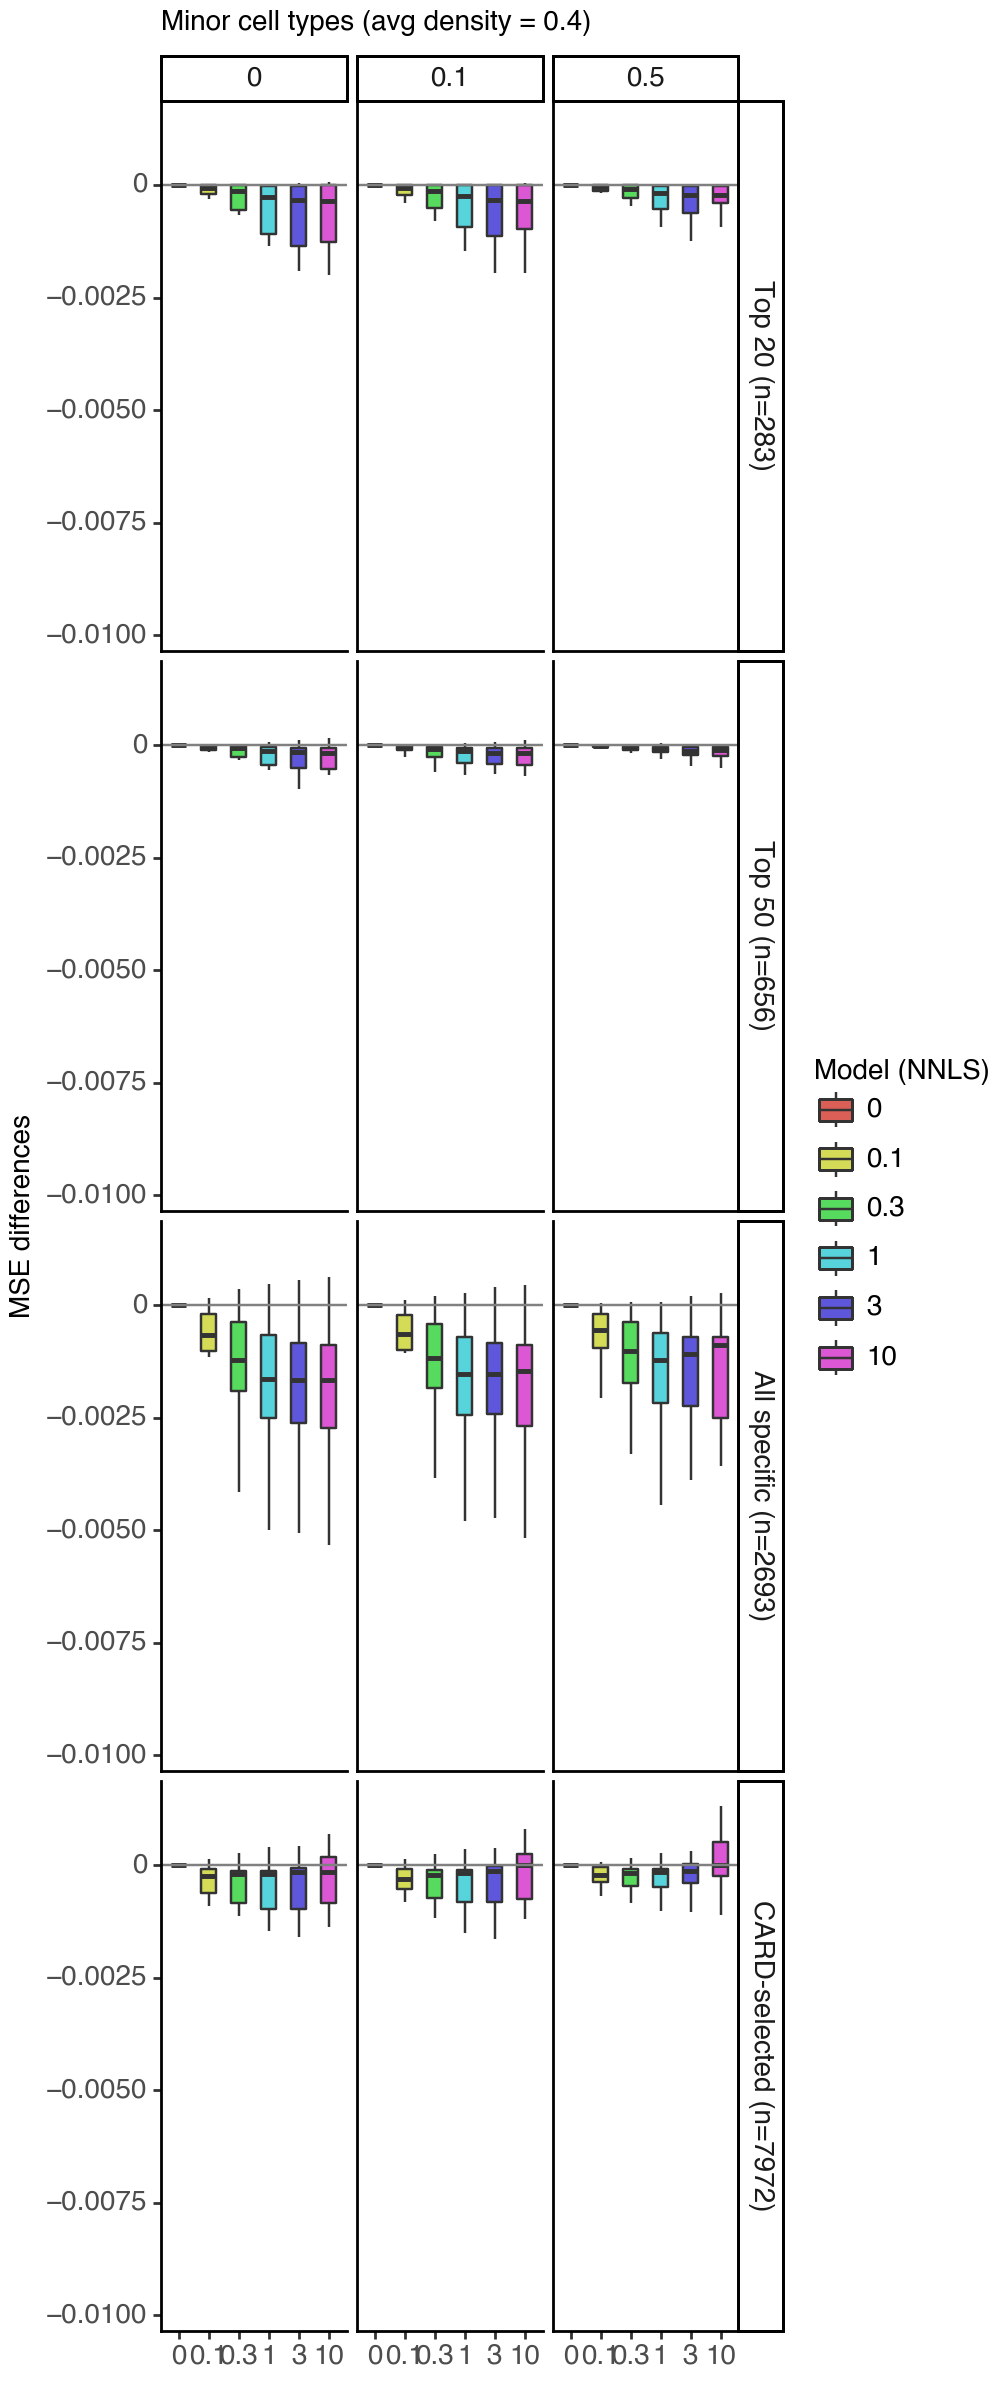

<Figure Size: (500 x 1200)>

In [7]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 0], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (NNLS)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

#### Pearson R

In [8]:
df = corr_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                   'exp', 'nm', 'sm'])
df_diff_corr = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                   'lambda_sp', 'is_high_density']]
df_diff_corr['corr_diff'] = df['corr'].to_numpy() - \
     np.repeat(df[df.lambda_sp == '0']['corr'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/58331188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


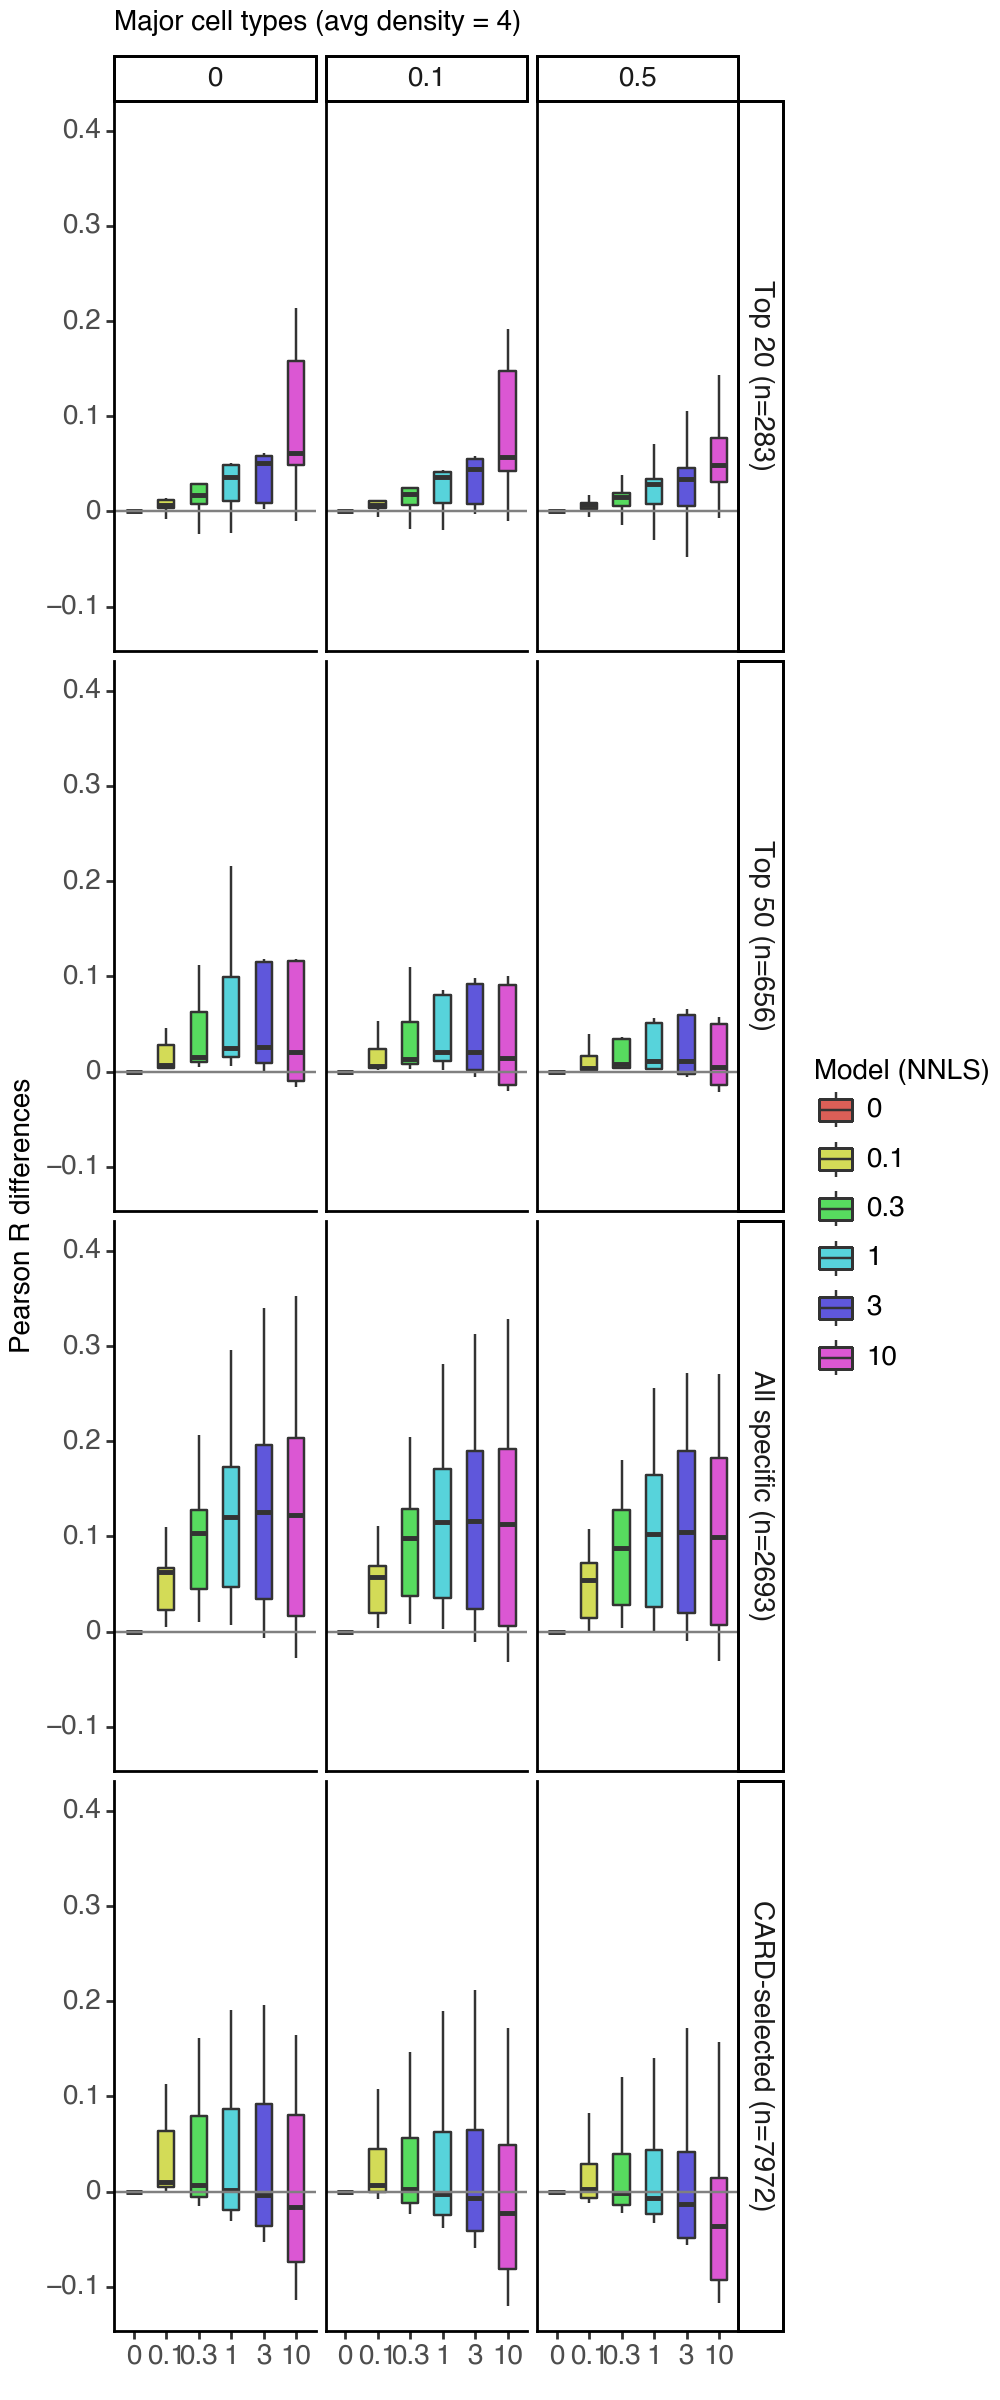

<Figure Size: (500 x 1200)>

In [9]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 1], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (NNLS)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

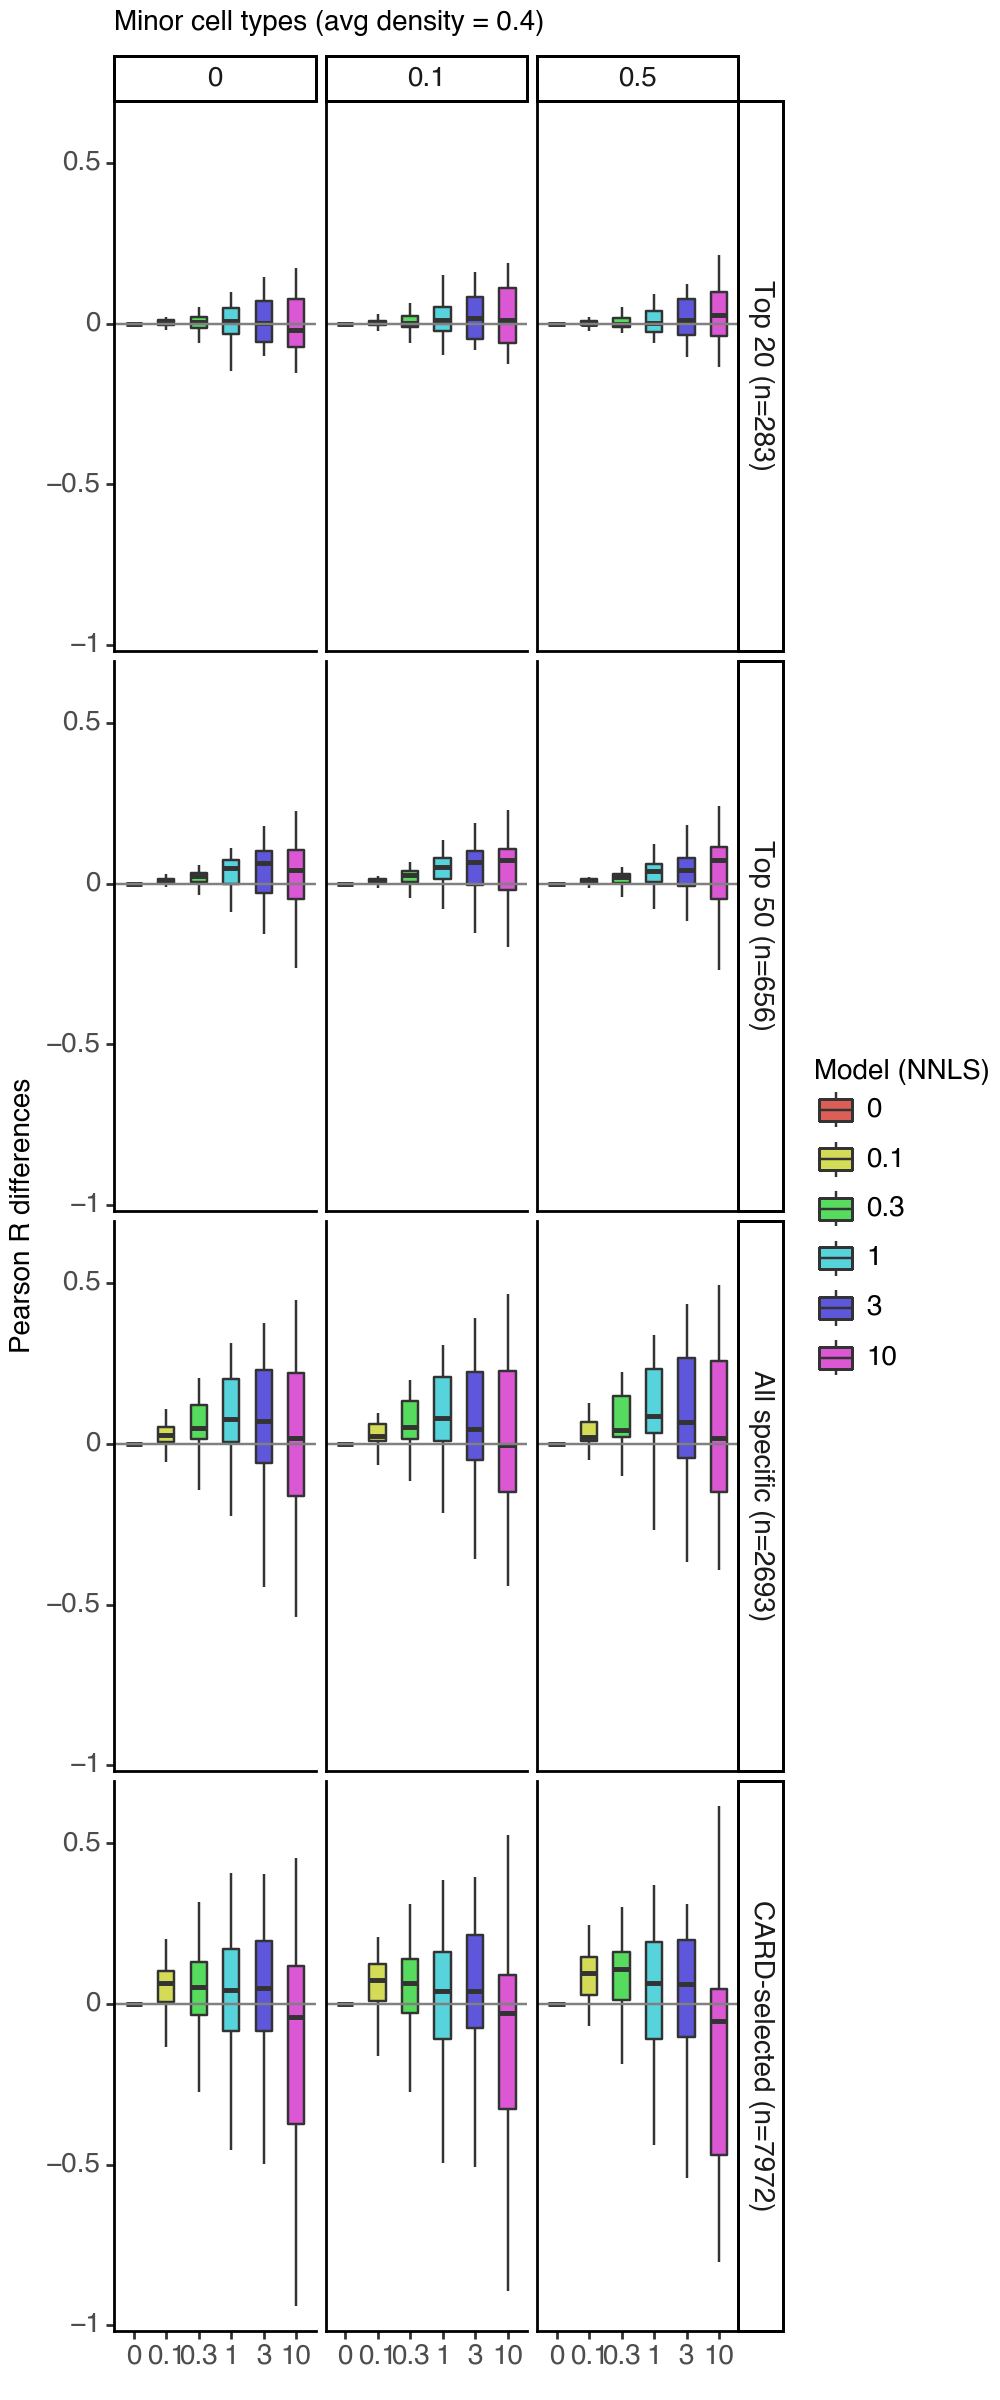

<Figure Size: (500 x 1200)>

In [10]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 0], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (NNLS)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

### DWLS

In [11]:
err_l = []
corr_l = []
accu_l = []
lambda_list = [0, 0.1, 0.3, 1, 3, 10]
method = 'dwls'
method_names = [f'{method}_sp{str(l)}' for l in lambda_list]

corr_metric='pearson'
accu_metric='pr'

for nm, sm in itertools.product(['c', '0', '20', '50'], ['0', '0.1', '0.5']):
    data_dir = f"{DATA_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/"
    res_dir = f"{RES_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/" + \
        f"lambda_sp_torch/{method}/"
    
    # load deconv results
    p_true_exp_list, p_inf_exp_list, design = load_deconv_results(data_dir, res_dir, method)
    
    # calculate performance stats
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        err_exp_df, corr_exp_df, accu_exp_df  = calc_deconv_stats(
            p_true_exp_list, p_inf_exp_list, design, method_names, corr_metric, accu_metric)
    
    err_exp_df['nm'] = nm
    err_exp_df['sm'] = sm
    corr_exp_df['nm'] = nm
    corr_exp_df['sm'] = sm
    accu_exp_df['nm'] = nm
    accu_exp_df['sm'] = sm
    
    err_l.append(err_exp_df)
    corr_l.append(corr_exp_df)
    accu_l.append(accu_exp_df)

def _list2df(l):
    df = pd.concat(l)
    df['deconv_model'] = df['deconv_model'].str.upper()
    df['nm'] = pd.Categorical(
        df.nm, ['20', '50', '0', 'c']
    ).rename_categories(dict_markers)
    return df
    
err_all_df = _list2df(err_l)
corr_all_df = _list2df(corr_l)
accu_all_df = _list2df(accu_l)

#### Absolute errors

In [12]:
df = err_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                  'exp', 'nm', 'sm'])
df_diff_err = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                  'lambda_sp', 'is_high_density']]
df_diff_err['err_diff'] = df['mse'].to_numpy() - \
    np.repeat(df[df.lambda_sp == '0']['mse'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/2732821099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


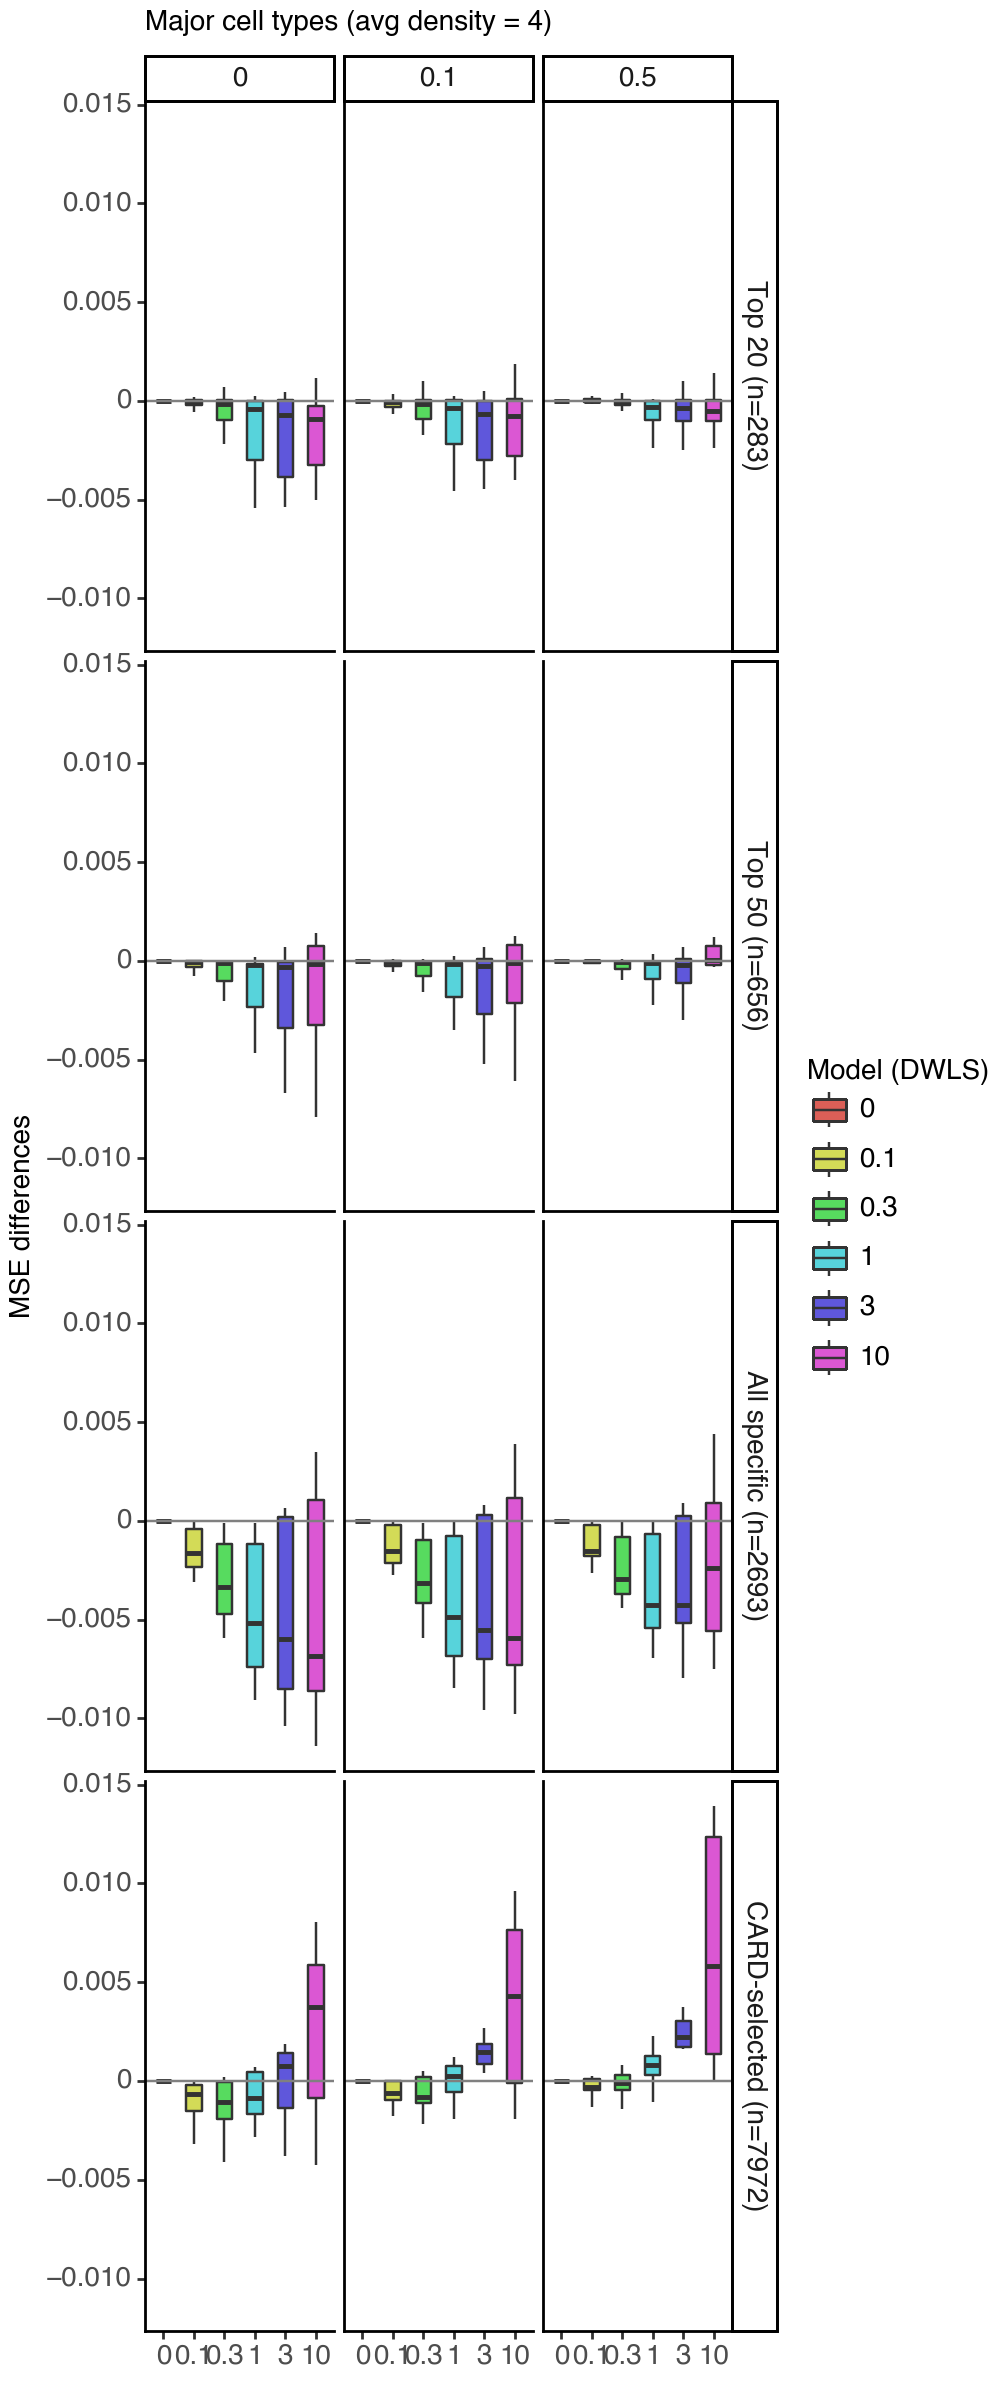

<Figure Size: (500 x 1200)>

In [13]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 1], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (DWLS)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

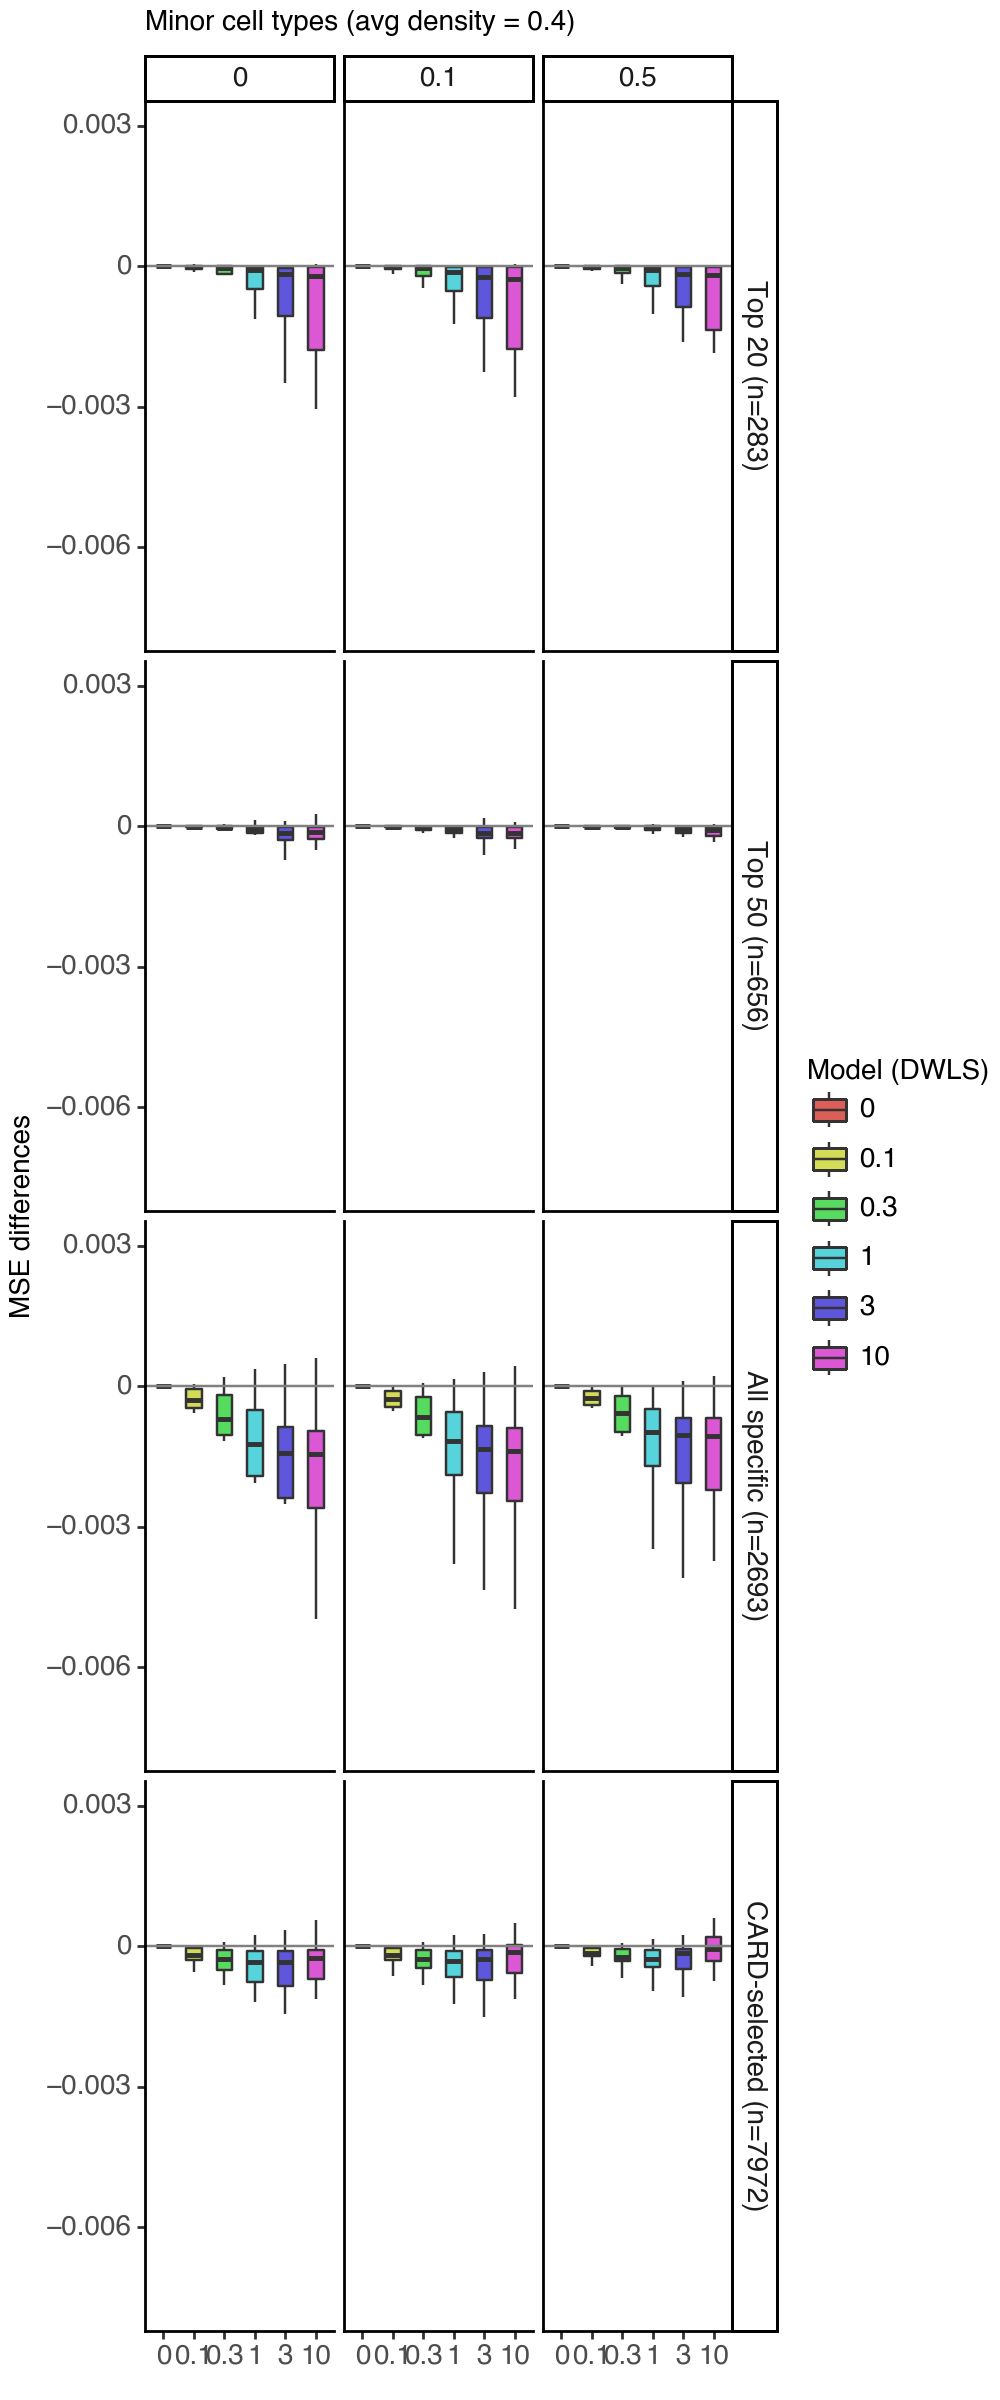

<Figure Size: (500 x 1200)>

In [14]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 0], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (DWLS)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

#### Pearson R

In [15]:
df = corr_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                   'exp', 'nm', 'sm'])
df_diff_corr = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                   'lambda_sp', 'is_high_density']]
df_diff_corr['corr_diff'] = df['corr'].to_numpy() - \
     np.repeat(df[df.lambda_sp == '0']['corr'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/58331188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


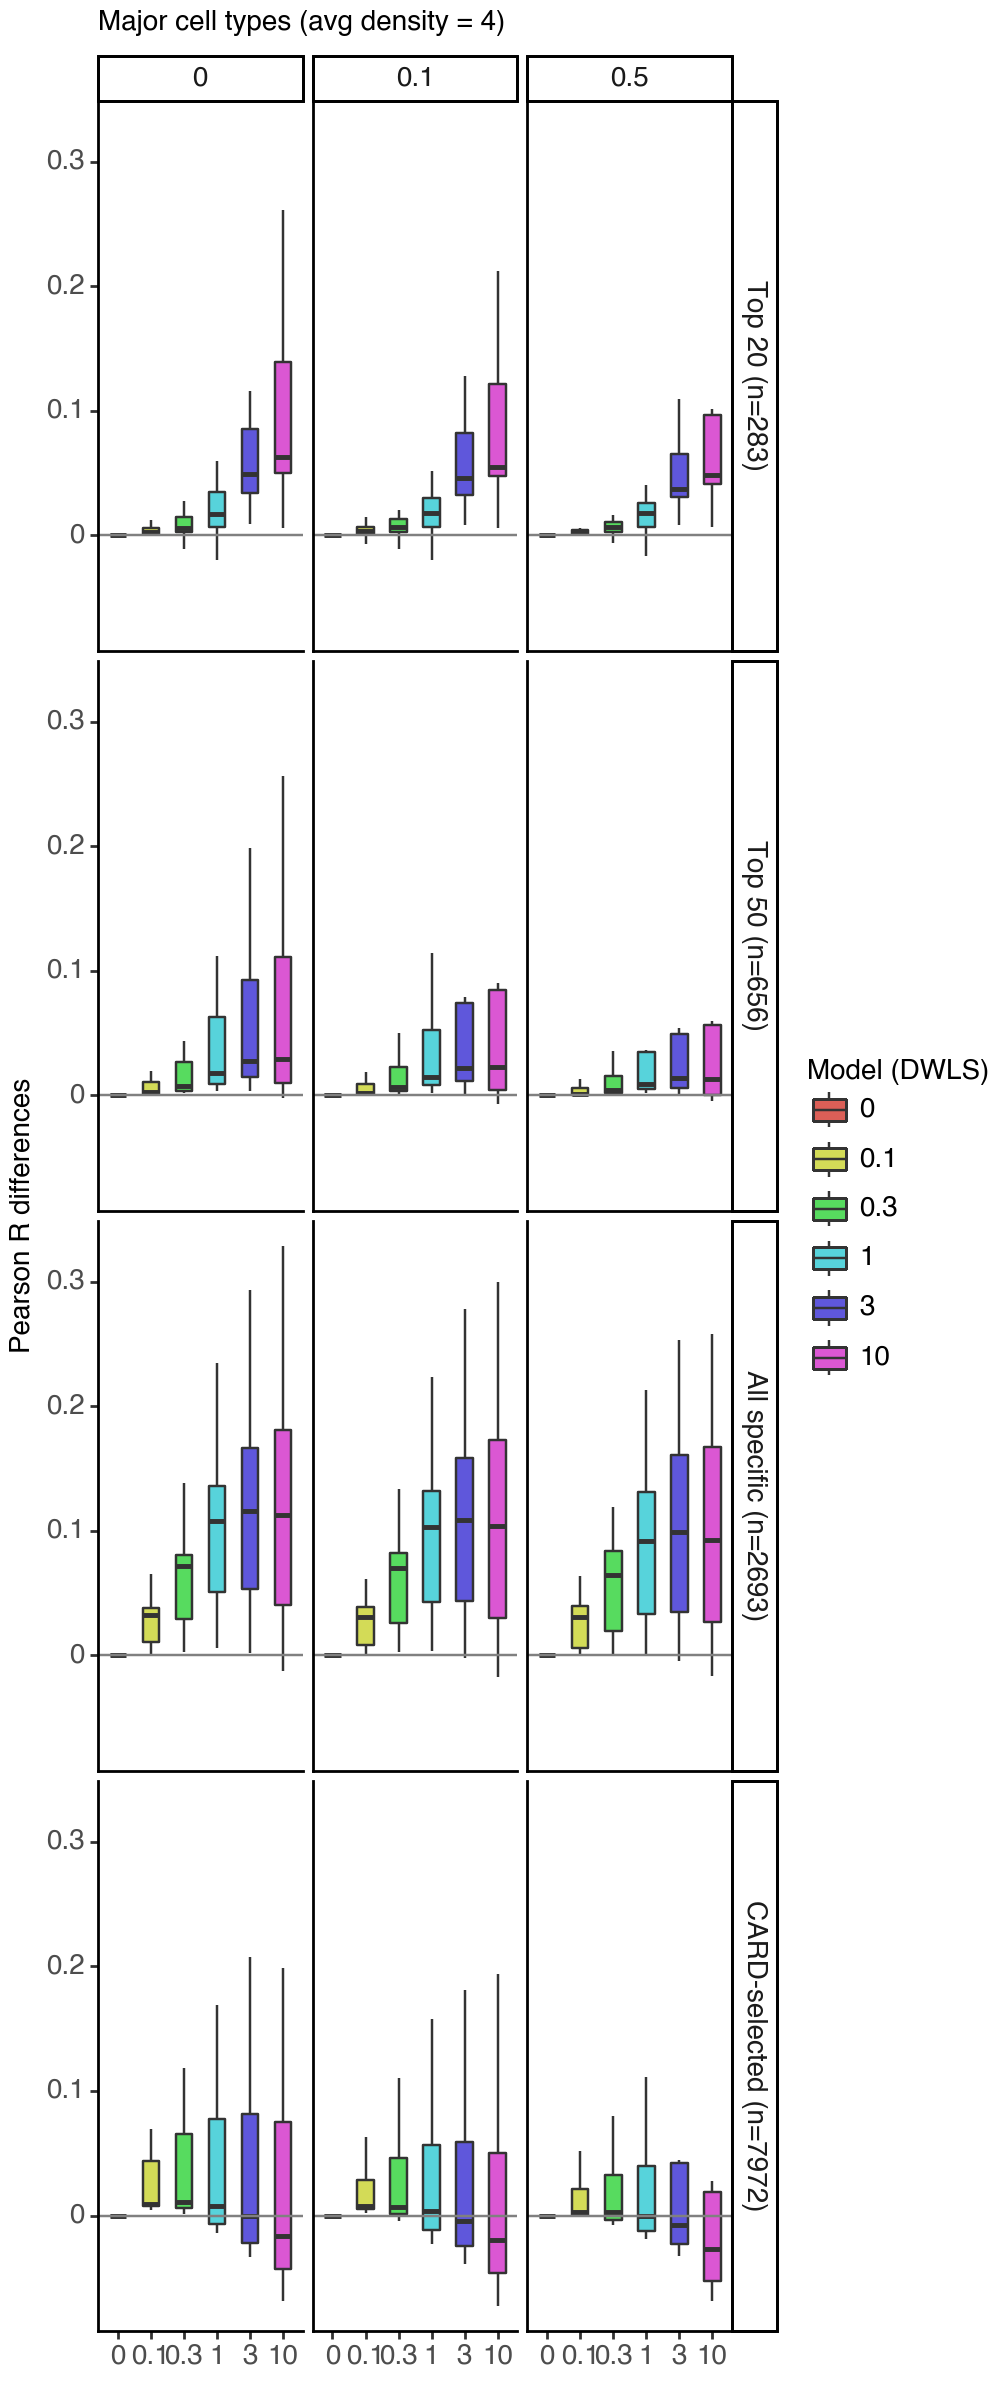

<Figure Size: (500 x 1200)>

In [16]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 1], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (DWLS)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

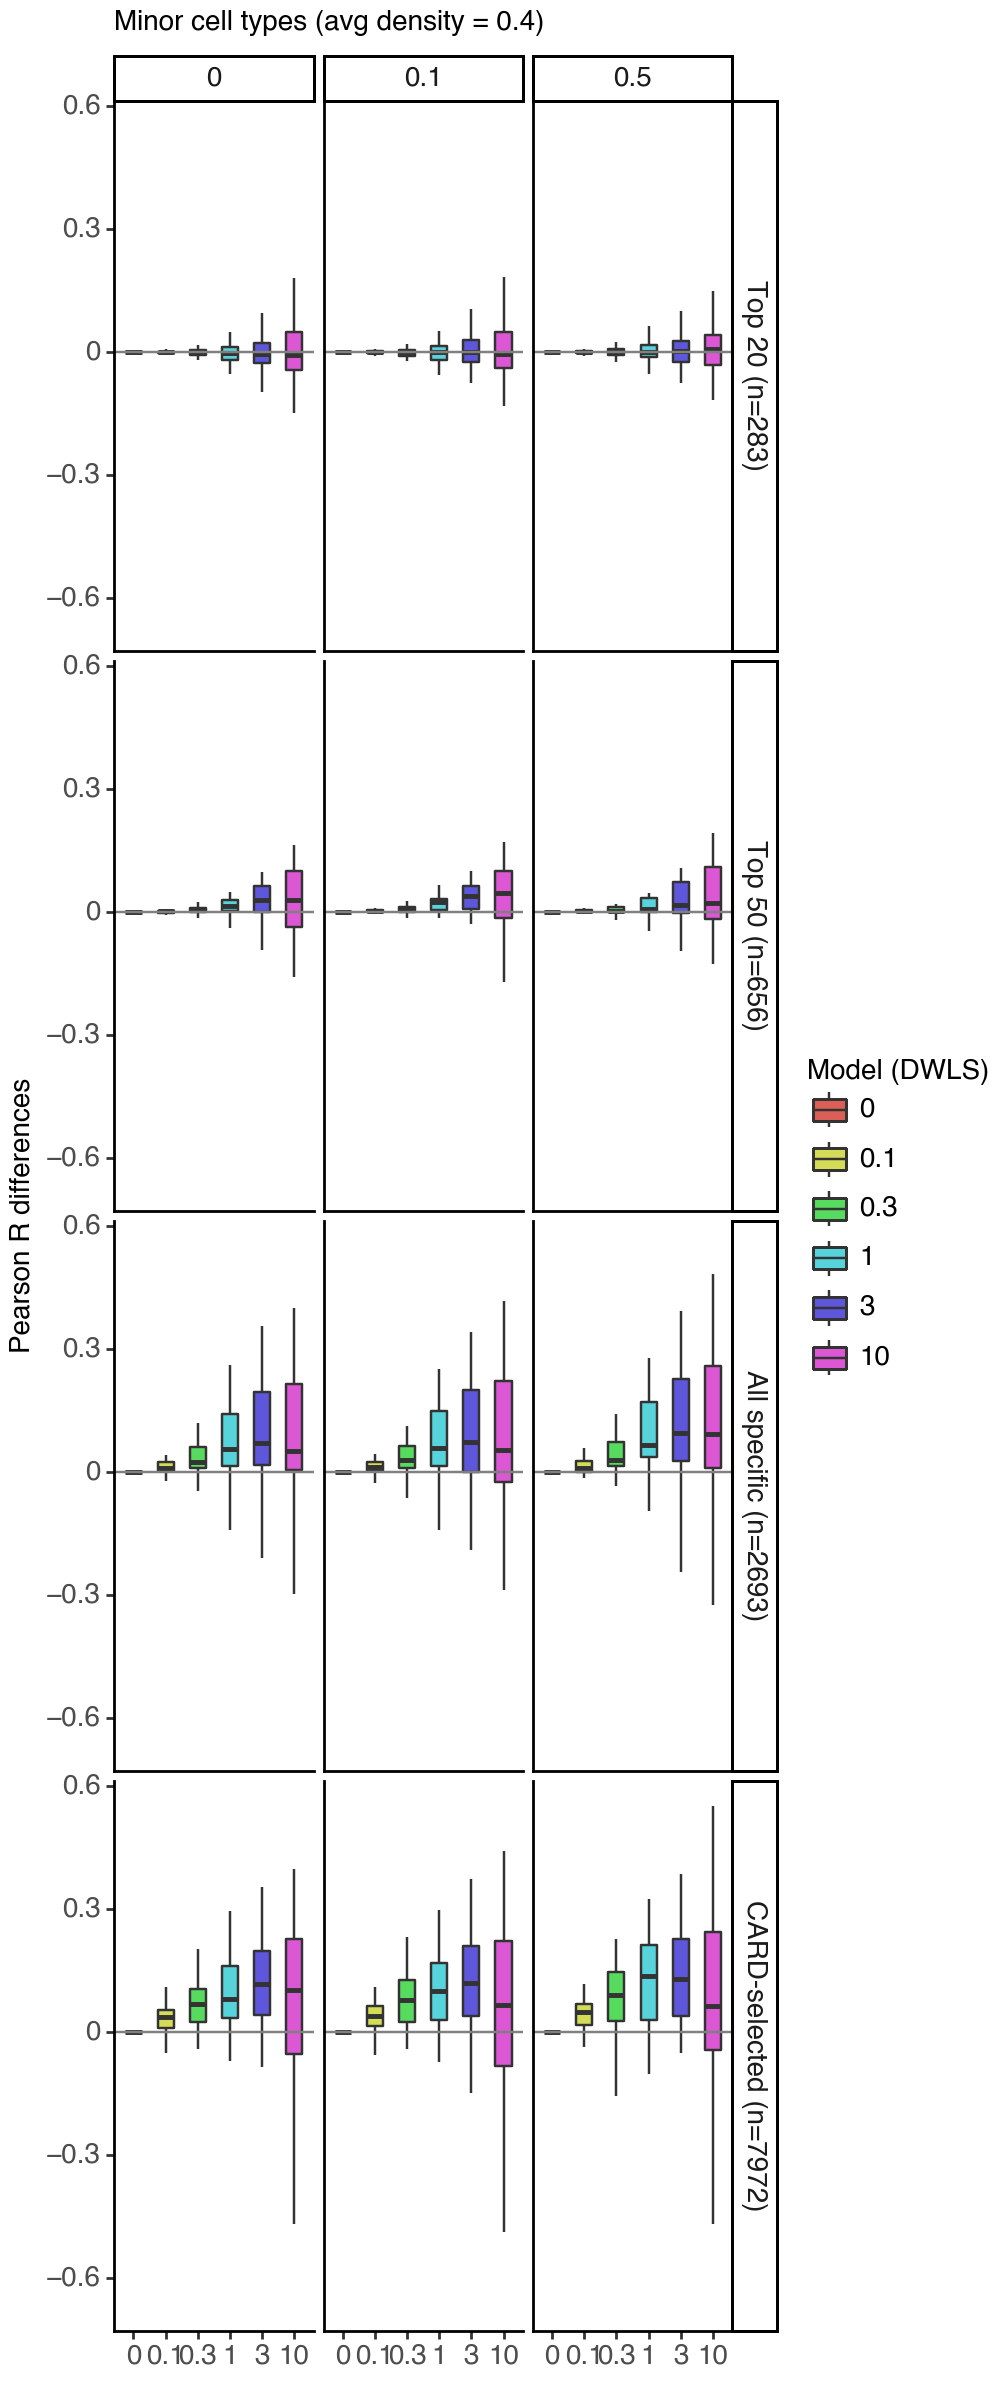

<Figure Size: (500 x 1200)>

In [17]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 0], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (DWLS)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

### SVR

In [18]:
err_l = []
corr_l = []
accu_l = []
lambda_list = [0, 0.1, 0.3, 1, 3, 10]
method = 'svr'
method_names = [f'{method}_sp{str(l)}' for l in lambda_list]

corr_metric='pearson'
accu_metric='pr'

for nm, sm in itertools.product(['c', '0', '20', '50'], ['0', '0.1', '0.5']):
    data_dir = f"{DATA_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/"
    res_dir = f"{RES_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/" + \
        f"lambda_sp_torch/{method}/"
    
    # load deconv results
    p_true_exp_list, p_inf_exp_list, design = load_deconv_results(data_dir, res_dir, method)
    
    # calculate performance stats
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        err_exp_df, corr_exp_df, accu_exp_df  = calc_deconv_stats(
            p_true_exp_list, p_inf_exp_list, design, method_names, corr_metric, accu_metric)
    
    err_exp_df['nm'] = nm
    err_exp_df['sm'] = sm
    corr_exp_df['nm'] = nm
    corr_exp_df['sm'] = sm
    accu_exp_df['nm'] = nm
    accu_exp_df['sm'] = sm
    
    err_l.append(err_exp_df)
    corr_l.append(corr_exp_df)
    accu_l.append(accu_exp_df)

def _list2df(l):
    df = pd.concat(l)
    df['deconv_model'] = df['deconv_model'].str.upper()
    df['nm'] = pd.Categorical(
        df.nm, ['20', '50', '0', 'c']
    ).rename_categories(dict_markers)
    return df
    
err_all_df = _list2df(err_l)
corr_all_df = _list2df(corr_l)
accu_all_df = _list2df(accu_l)

#### Absolute errors

In [19]:
df = err_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                  'exp', 'nm', 'sm'])
df_diff_err = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                  'lambda_sp', 'is_high_density']]
df_diff_err['err_diff'] = df['mse'].to_numpy() - \
    np.repeat(df[df.lambda_sp == '0']['mse'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/2732821099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


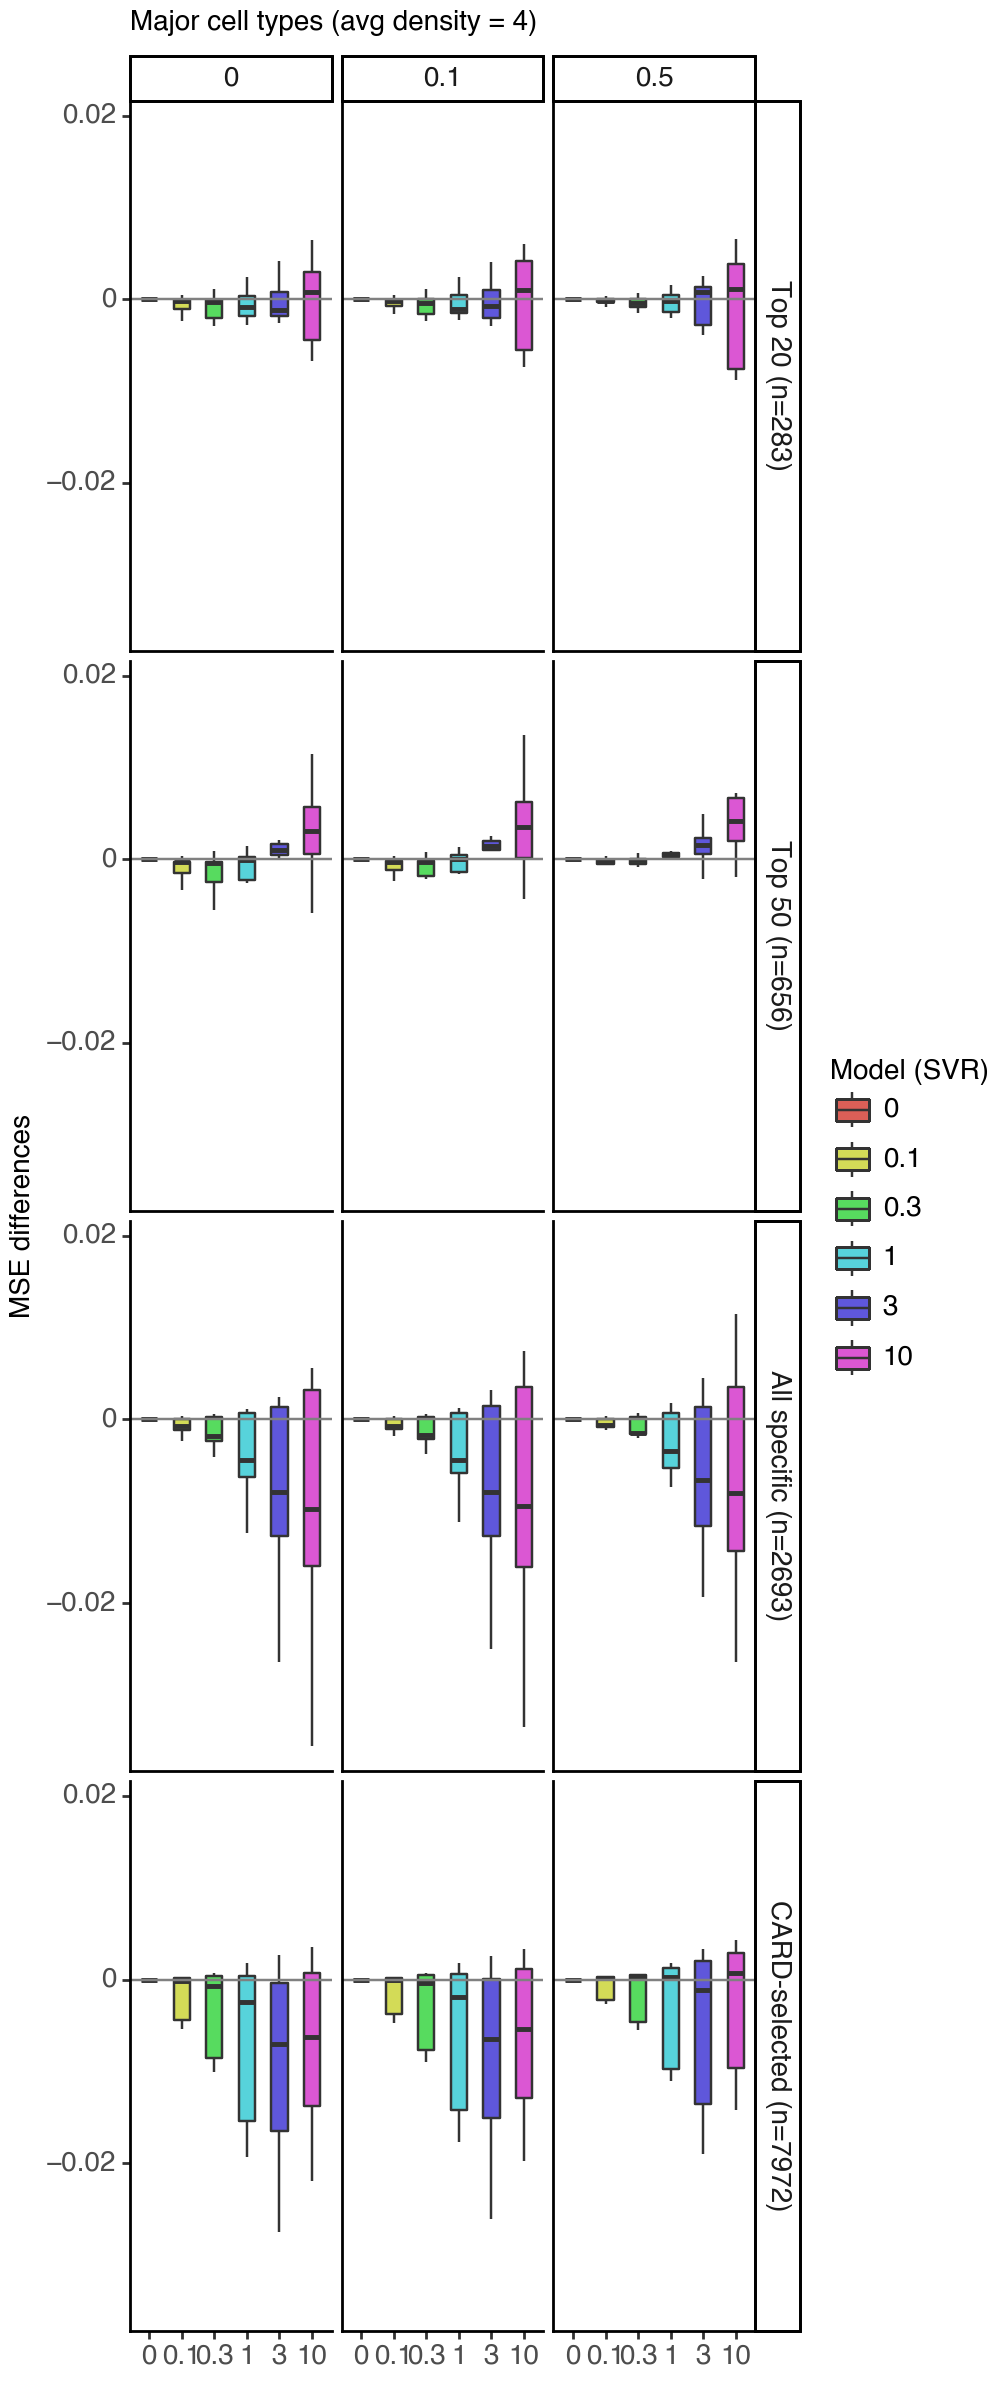

<Figure Size: (500 x 1200)>

In [20]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 1], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (SVR)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

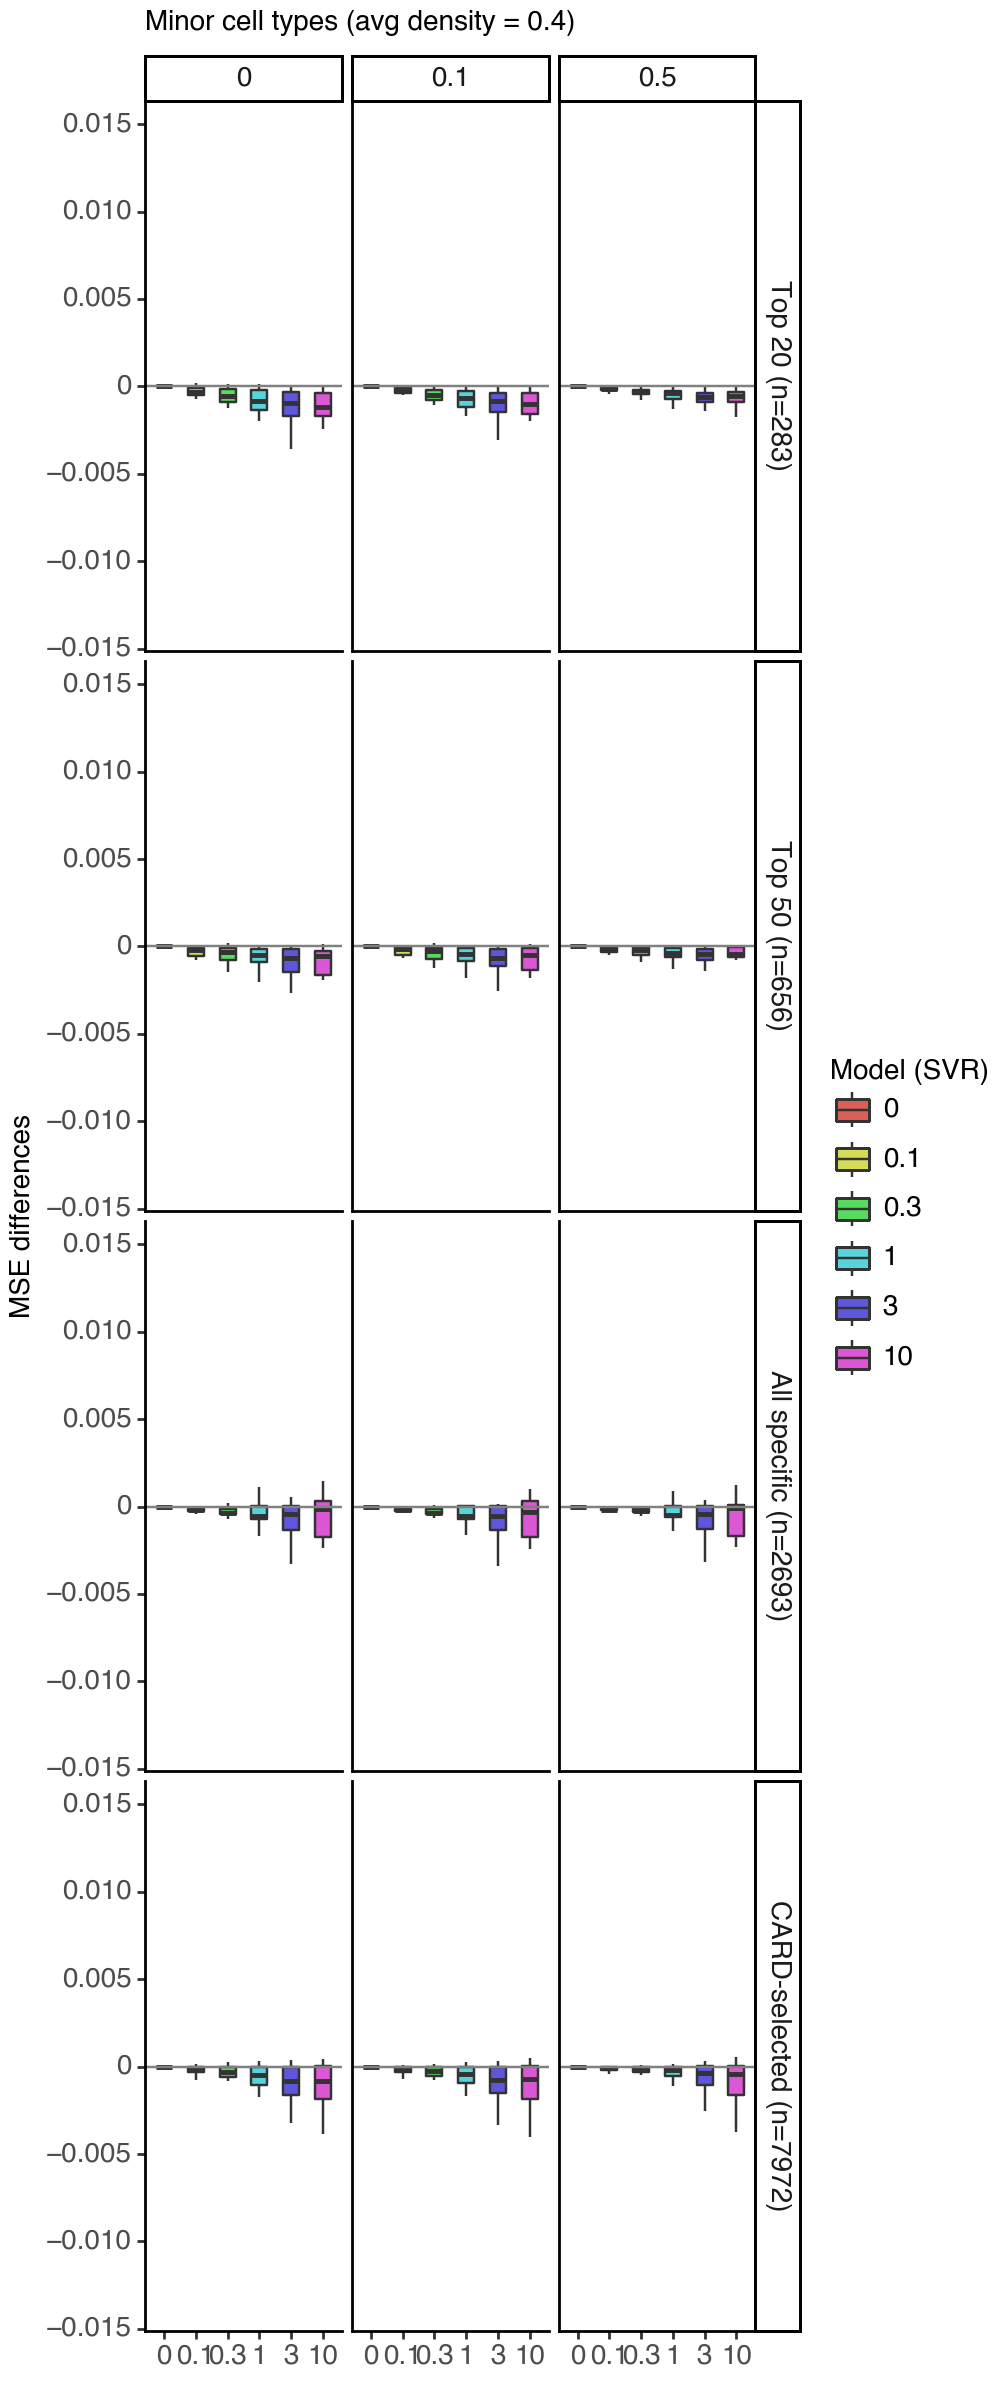

<Figure Size: (500 x 1200)>

In [21]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 0], 
           aes(x='lambda_sp', y = 'err_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'MSE differences', fill = 'Model (SVR)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

#### Pearson R

In [22]:
df = corr_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                   'exp', 'nm', 'sm'])
df_diff_corr = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                   'lambda_sp', 'is_high_density']]
df_diff_corr['corr_diff'] = df['corr'].to_numpy() - \
     np.repeat(df[df.lambda_sp == '0']['corr'].to_numpy(), len(method_names))

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_32206/58331188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


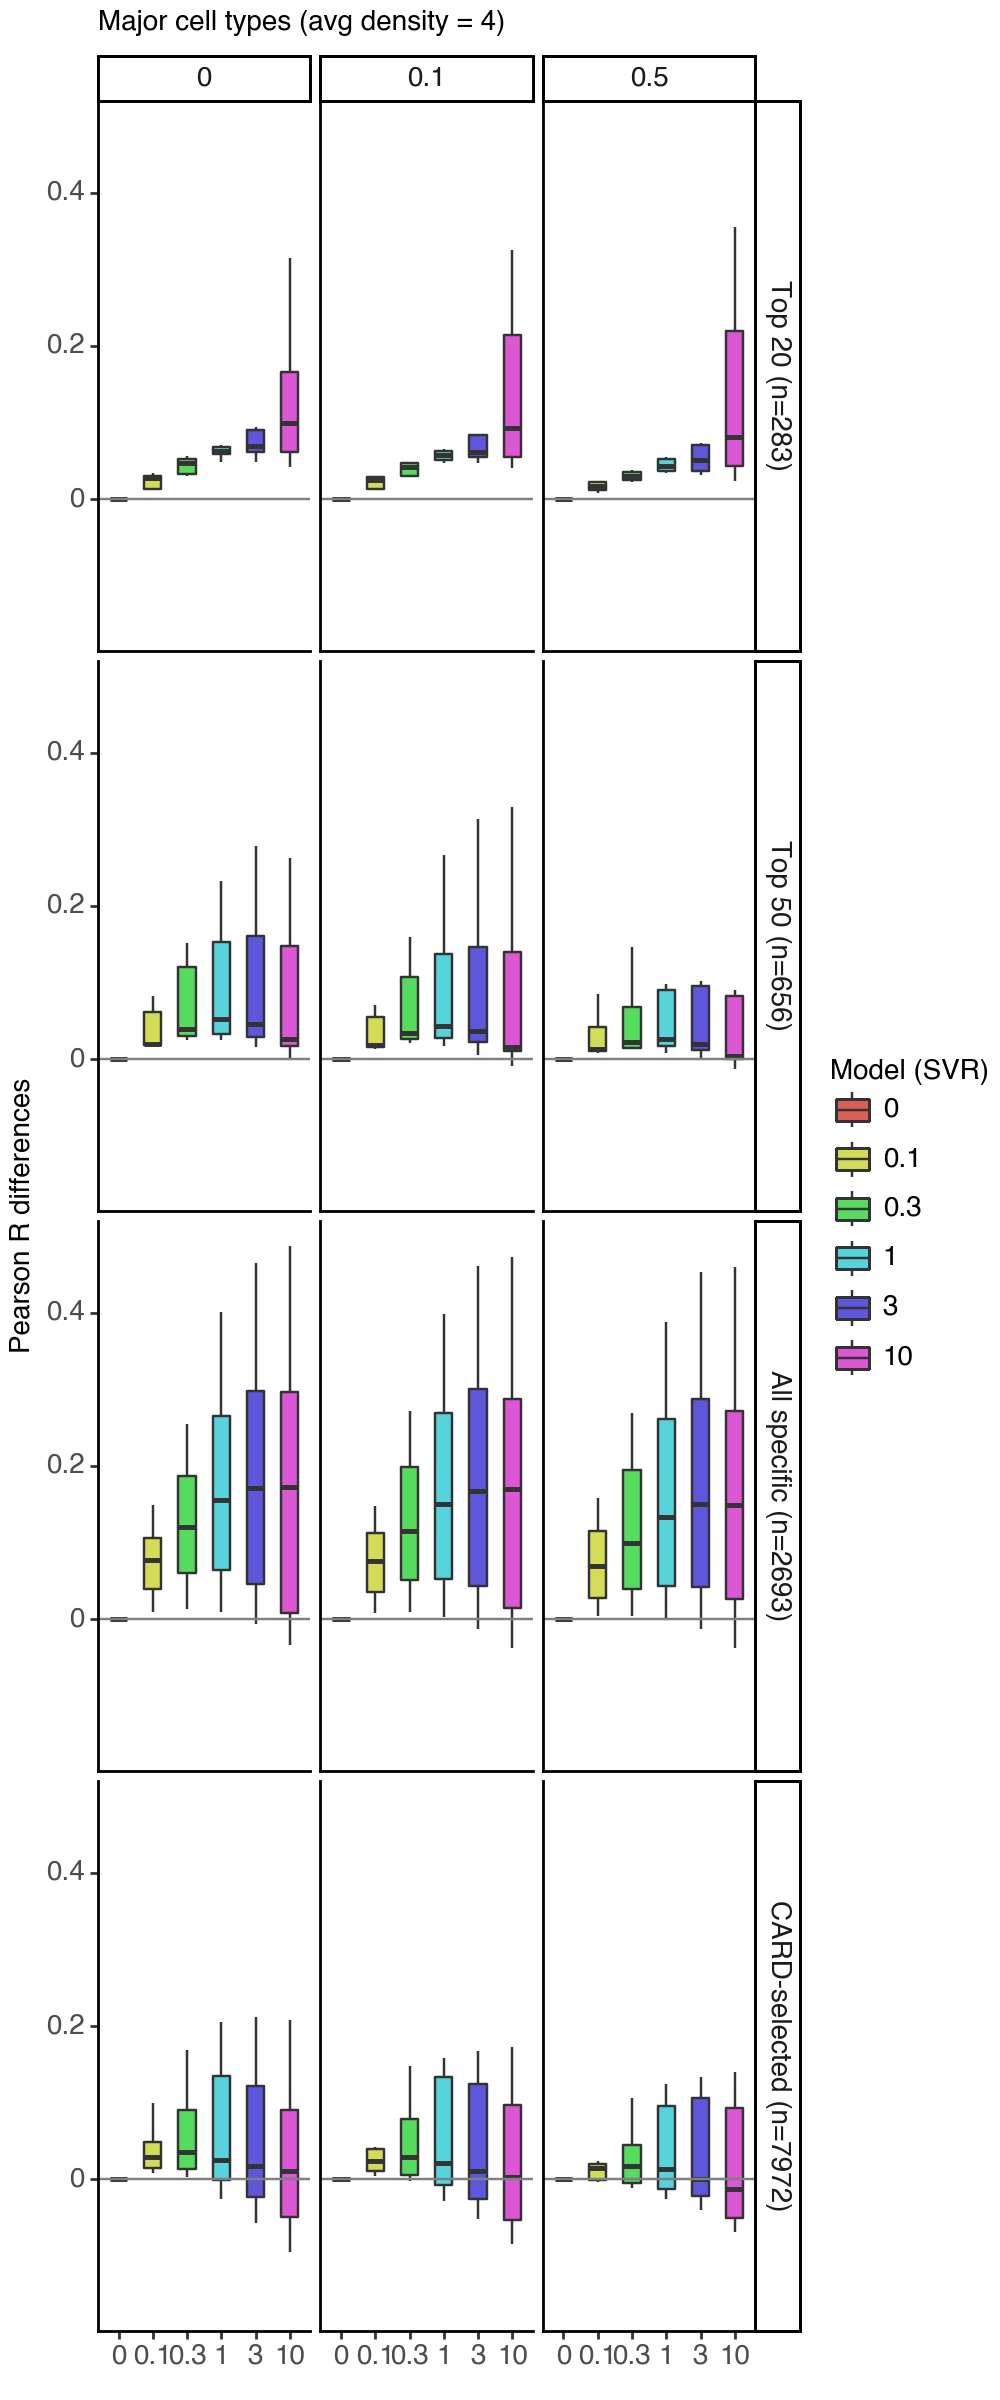

<Figure Size: (500 x 1200)>

In [23]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 1], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (SVR)',
         title = 'Major cell types (avg density = 4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)

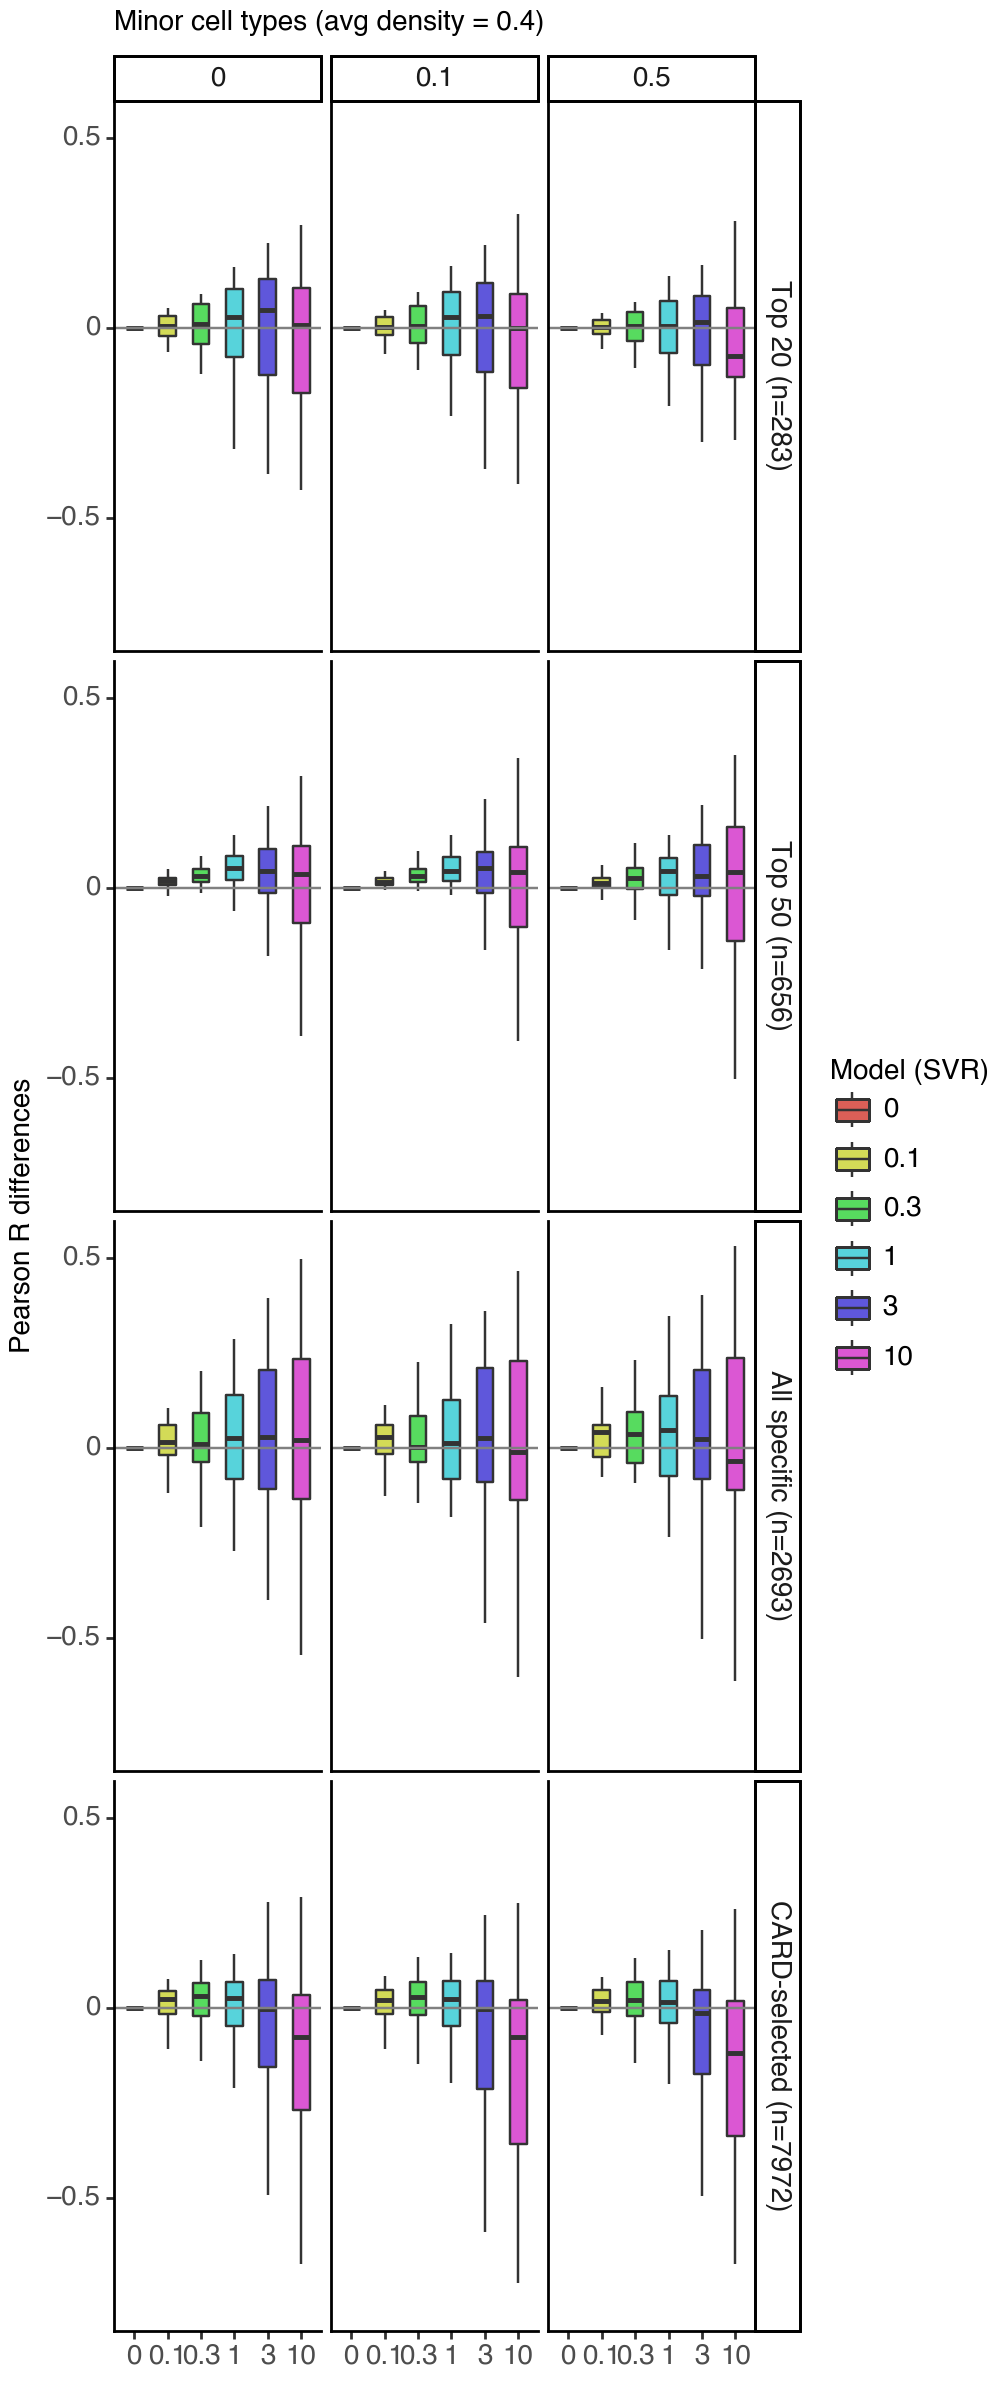

<Figure Size: (500 x 1200)>

In [24]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 0], 
           aes(x='lambda_sp', y = 'corr_diff', group = 'lambda_sp')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'lambda_sp'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model (SVR)',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12),
          text = element_text(size = 10))
)